# NLP2022 - Homework 2


This notebook contains code for a fast processing of data and experiments execution for the second homework of the course Natural Language Processing 2022. It has been completely wrote by Dennis Rotondi 1834864 using the methodologies learned throughout the course.

In [89]:
# imports and deterministic stuff
import os, sys
sys.path.append(os.path.join("..")) #to access hw2 functions
sys.path.append(os.path.join("../..")) #to access model folder
os.environ['WANDB_NOTEBOOK_NAME'] = './nlp_hw2.ipynb' # to avoid a wandb warning
os.environ['TOKENIZERS_PARALLELISM'] = "false" # to avoid deadlock at traning time for the tokenizer

import torch
import numpy as np
import random
import pytorch_lightning as pl
from collections import Counter
import matplotlib.pyplot as plt
from utils import read_dataset
import wandb
from pytorch_lightning.loggers.wandb import WandbLogger

np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False
_ = pl.seed_everything(0)

# to have a better workflow using notebook https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
# these commands allow to update the .py codes imported instead of re-importing everything every time.
%load_ext autoreload
%autoreload 2

Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Analysis

As for the bonus exercise and hw1, I want to start by looking at the data I have to better understand how to proceed in the pre-processing operations. I've read that there are problems with some (sentence-ground truth) pairs, since we are not allowed to do any change I'll directly discharge them for the training phase if needed. I'll do my analysis mostly for the english dataset since it is mandatory and larger 

(it's possible to reproduce the experiments in different languages just changing the language parameter that follow from "EN" to {"ES", "FR"}).

In [72]:
language = "EN" # "ES" or "FR" if you want
data_file = f"../../data/{language}/train.json"

sentences, labels = read_dataset(data_file)
print(f"Number of training sentences ({language}): "+ str(len(sentences.keys())))
# I'm just playing with the field of a sentence_id to understand our data samples.
sentence_id = list(sentences.keys())[0]
print("## SENTENCE {} ##".format(sentence_id))
for key in sentences[sentence_id]:
    print(key)
    print(sentences[sentence_id][key])
print("## LABEL ##")
for key in labels[sentence_id]:
    print(key)
    print(labels[sentence_id][key])

# let's check and count the different frames and roles
verbatlas_frames = Counter()
predicate_roles = Counter()
pos_tags = Counter()

for k in labels:
    verbatlas_frames.update(labels[k]['predicates'])
    pos_tags.update(sentences[k]['pos_tags'])
    for idx in labels[k]['roles']:
        predicate_roles.update(labels[k]['roles'][idx])

Number of training sentences (EN): 5501
## SENTENCE 1996/a/50/18_supp__323:5 ##
words
['Members', 'also', 'asked', 'whether', 'all', 'social', 'groups', 'enjoyed', 'equal', 'access', 'to', 'higher', 'education', '.']
lemmas
['member', 'also', 'ask', 'whether', 'all', 'social', 'group', 'enjoy', 'equal', 'access', 'to', 'higher', 'education', '.']
pos_tags
['NOUN', 'ADV', 'VERB', 'SCONJ', 'DET', 'ADJ', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'PUNCT']
dependency_heads
[3, 3, 0, 8, 7, 7, 8, 3, 10, 8, 13, 13, 10, 3]
dependency_relations
['nsubj', 'advmod', 'root', 'mark', 'det', 'amod', 'nsubj', 'ccomp', 'amod', 'obj', 'case', 'amod', 'nmod', 'punct']
predicates
['_', '_', 'ASK_REQUEST', '_', '_', '_', '_', 'BENEFIT_EXPLOIT', '_', '_', '_', '_', '_', '_']
## LABEL ##
predicates
['_', '_', 'ASK_REQUEST', '_', '_', '_', '_', 'BENEFIT_EXPLOIT', '_', '_', '_', '_', '_', '_']
roles
{2: ['agent', '_', '_', 'theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 7: ['_', '_', '_'

In [73]:
print("## VF ##")
print(verbatlas_frames)
# list of frames in the training dataset
l_vf = list(verbatlas_frames.keys())
print(l_vf)
print(len(l_vf))
print("## RL ##")
print(predicate_roles)
p_r = list(predicate_roles.keys())
print(p_r)
print(len(p_r))
print("## PT ##")
ppl = list(pos_tags.keys())
print(ppl)
print(len(ppl))

## VF ##
Counter({'_': 170997, 'PROPOSE': 542, 'CARRY-OUT-ACTION': 492, 'INCLUDE-AS': 472, 'SPEAK': 393, 'INCREASE_ENLARGE_MULTIPLY': 350, 'SHOW': 287, 'ASK_REQUEST': 271, 'CONTINUE': 270, 'GUARANTEE_ENSURE_PROMISE': 262, 'APPROVE_PRAISE': 257, 'FOLLOW_SUPPORT_SPONSOR_FUND': 237, 'LOAD_PROVIDE_CHARGE_FURNISH': 235, 'GIVE_GIFT': 228, 'REQUIRE_NEED_WANT_HOPE': 214, 'OBLIGE_FORCE': 200, 'AGREE_ACCEPT': 197, 'DECIDE_DETERMINE': 189, 'HELP_HEAL_CARE_CURE': 179, 'INCITE_INDUCE': 175, 'FOCUS': 162, 'STRENGTHEN_MAKE-RESISTANT': 160, 'BEGIN': 157, 'INFORM': 152, 'ESTABLISH': 150, 'AMELIORATE': 148, 'TAKE-INTO-ACCOUNT_CONSIDER': 146, 'ANALYZE': 130, 'ORGANIZE': 126, 'USE': 118, 'NAME': 116, 'CREATE_MATERIALIZE': 113, 'FINISH_CONCLUDE_END': 112, 'EMPHASIZE': 110, 'PRECLUDE_FORBID_EXPEL': 101, 'SEE': 96, 'REFER': 94, 'ANSWER': 94, 'PUT_APPLY_PLACE_PAVE': 87, 'CANCEL_ELIMINATE': 86, 'ACHIEVE': 83, 'ASSIGN-SMT-TO-SMN': 79, 'REDUCE_DIMINISH': 78, 'POSSESS': 73, 'SUMMON': 68, 'ALLY_ASSOCIATE_MARRY': 6

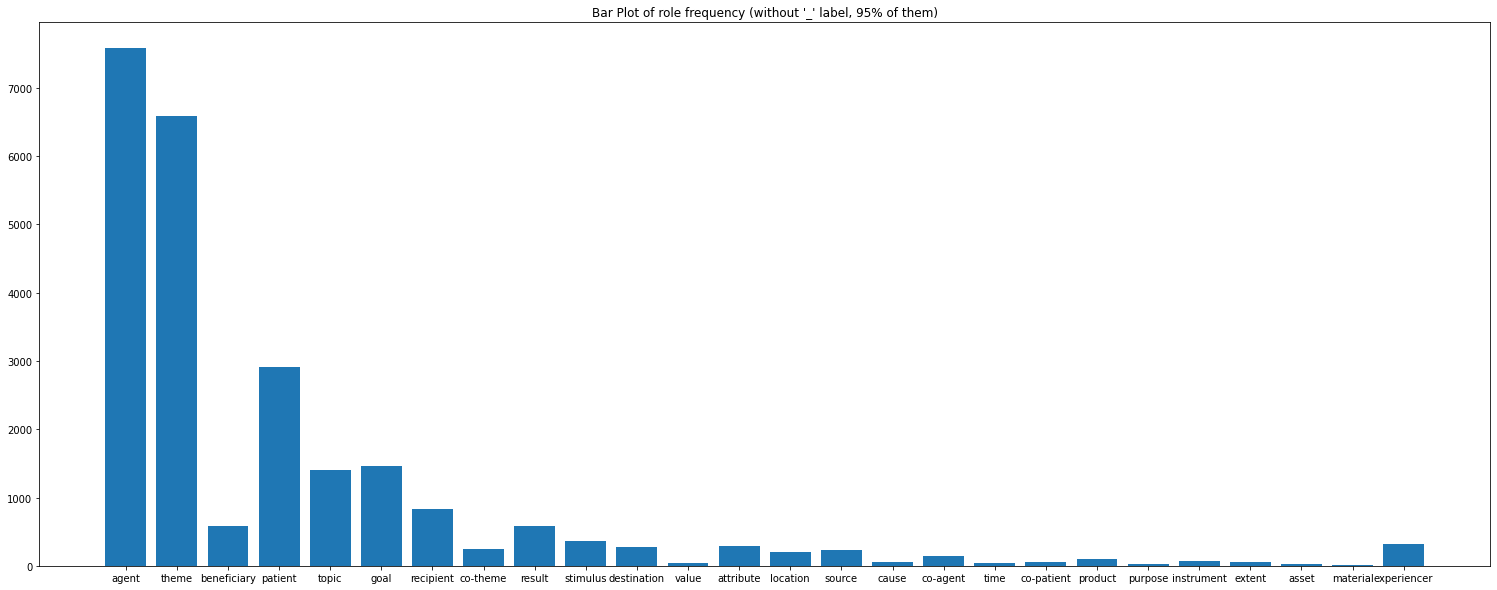

In [74]:
del(predicate_roles["_"])
# to place it in a different position and not have overlapping labels
predicate_roles["experiencer"] = predicate_roles.pop("experiencer")
plt.figure(figsize=(26,10))
_ = plt.bar(predicate_roles.keys(), predicate_roles.values()) 
plt.title("Bar Plot of role frequency (without '_' label, 95% of them)") 
plt.show() #it's possible to notice that most of them are between size 7 and 30

We are clearly not using all the 466 [verbatlas](https://verbatlas.org/) frames but less than 3/4 of them: 303. Working with fewer clusters surely increases the overall performances because the system can only focus on a subset of them. In the next code cell I want to check if in the dev-set I do not have other frames.

In [75]:
dev_sentences, dev_labels = read_dataset(f"../../data/{language}/dev.json")
print(f"Number of training sentences ({language}): "+ str(len(dev_sentences.keys())))
for k in dev_labels:
    verbatlas_frames.update(dev_labels[k]['predicates'])
    for idx in dev_labels[k]['roles']:
        predicate_roles.update(dev_labels[k]['roles'][idx])

l_vf_dev = list(verbatlas_frames.keys())
print(len(l_vf_dev))

Number of training sentences (EN): 1026
307


So there are only 4 more frames in the dev_set wrt the train_set, this information is useful for further consideration when I'll deal with the optional part of this homework.

Now that I'm starting to understand the samples, it's clear that our dataset does not need much pre-processing, since we already have words tokens and associated lemmas for each sentence. Some more useful statistics are on how long are the sentences on average, how many predicates they have and how the distribution of pos-tagging tokens correlate with roles and predicates. I'll rapidly compute them in what follows. 

In [76]:
from mergedeep import merge
sentences_length = list()
predicates_counter = list()
sentences = merge(sentences, labels)
pos_pre_corr = Counter()
pos_role_corr = Counter()

Sentences Length
mean 33.36829667333212
std 15.785117622745254
min 12
max 99
Predicates Counter
mean 2.283584802763134
std 1.296283313397536
min 0
max 10


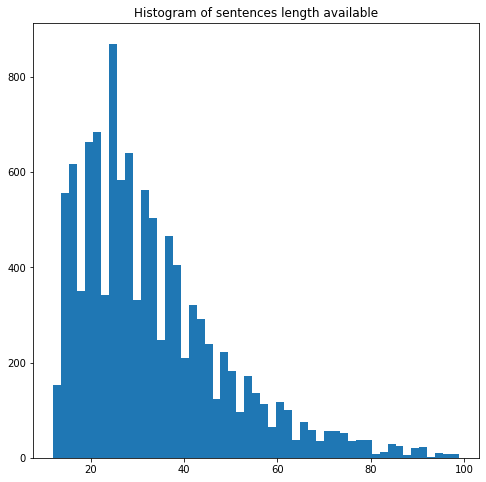

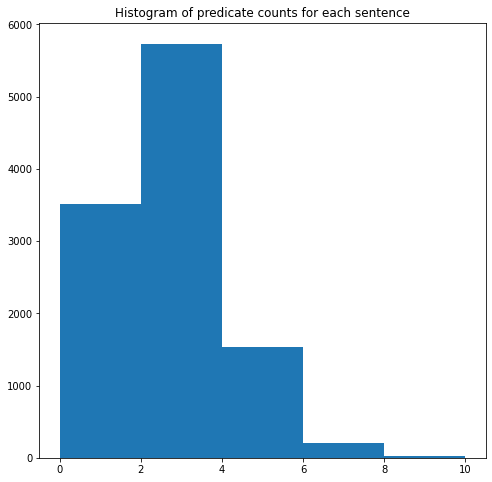

In [95]:
p_tags = list(pos_tags.keys())
for pt in pos_tags:
    pos_pre_corr.update({pt:0})
    pos_role_corr.update({pt:0})

for s in sentences:
    s_l = len(sentences[s]["lemmas"])
    roles = sentences[s]["roles"].keys()
    p_c = len(roles)
    sentences_length.append(s_l)
    predicates_counter.append(p_c)
    for pos, predicate in zip(sentences[s]["pos_tags"], sentences[s]["predicates"]):
        if predicate != "_":
            pos_pre_corr.update({pos:1})
    for r in roles:
        for pos, role in zip(sentences[s]["pos_tags"],sentences[s]["roles"][r]):
            if role != "_":
                pos_role_corr.update({pos:1})
    
sl_np=np.asarray(sentences_length)
pc_np=np.asarray(predicates_counter)

print("Sentences Length")
print("mean", sl_np.mean())
print("std", sl_np.std())
print("min", sl_np.min())
print("max", sl_np.max())

print("Predicates Counter")
print("mean", pc_np.mean())
print("std", pc_np.std())
print("min", pc_np.min())
print("max", pc_np.max())

plt.figure(figsize=(8,8)) 
_ = plt.hist(sl_np, bins = 'auto') 
plt.title("Histogram of sentences length available") 
plt.show()

plt.figure(figsize=(8,8)) 
_ = plt.hist(pc_np, bins = 5) 
plt.title("Histogram of predicate counts for each sentence") 
plt.show()

It's interesting to notice that (for our EN dataset) there are some sentences with 0 and some with 10 predicates, even if the average is slightly more than 2.


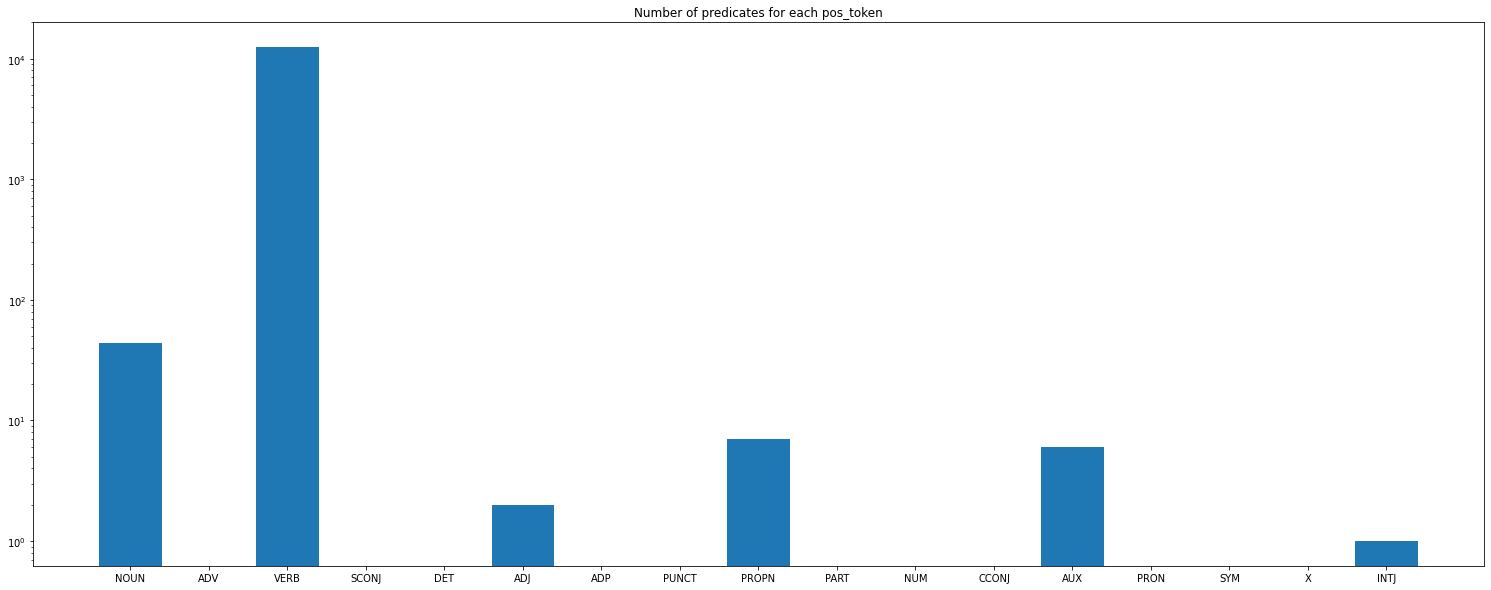

Counter({'VERB': 12502, 'NOUN': 44, 'PROPN': 7, 'AUX': 6, 'ADJ': 2, 'INTJ': 1, 'ADV': 0, 'SCONJ': 0, 'DET': 0, 'ADP': 0, 'PUNCT': 0, 'PART': 0, 'NUM': 0, 'CCONJ': 0, 'PRON': 0, 'SYM': 0, 'X': 0})


In [78]:
plt.figure(figsize=(26,10))
_ = plt.bar(pos_pre_corr.keys(), pos_pre_corr.values(), log=True) 
plt.title("Number of predicates for each pos_token") 
plt.show() #it's possible to notice that most of them are between size 7 and 30

print(pos_pre_corr)

A photo is worth a thousand words, if we are able to identify the pos_tag it's also very easy to understand we have a verb or not. (holy grail for task1)

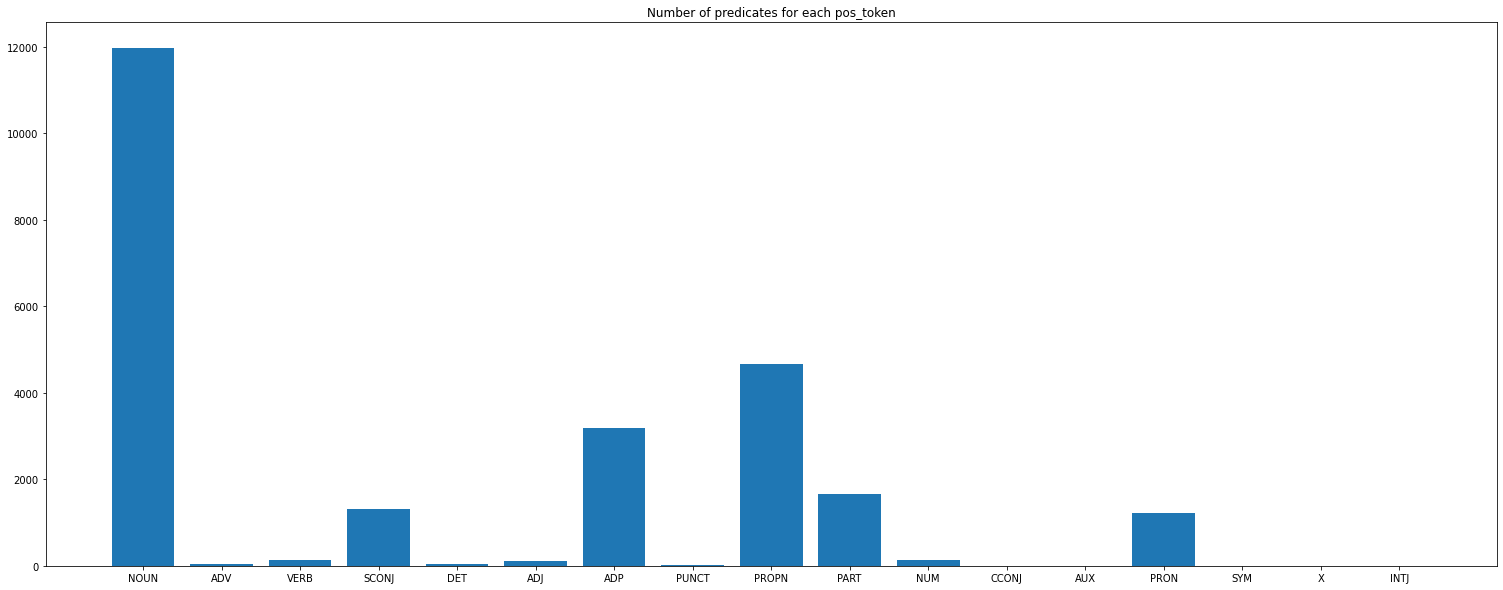

Counter({'NOUN': 11970, 'PROPN': 4655, 'ADP': 3179, 'PART': 1662, 'SCONJ': 1318, 'PRON': 1225, 'VERB': 144, 'NUM': 141, 'ADJ': 111, 'ADV': 43, 'DET': 32, 'PUNCT': 15, 'SYM': 4, 'AUX': 3, 'X': 3, 'CCONJ': 1, 'INTJ': 0})


In [79]:
plt.figure(figsize=(26,10))
_ = plt.bar(pos_role_corr.keys(), pos_role_corr.values()) 
plt.title("Number of predicates for each pos_token") 
plt.show() #it's possible to notice that most of them are between size 7 and 30

print(pos_role_corr)

Also in this case it's clear that there are pos tags that gives more information about which are the arguments, so I'll introduce them in my model if time will allow it.

Now that we have understood the importance of having a postag information, taking into account that the input sentence on which my work will be evaluated does not have pos-tag information, I have to retrieve them with an external library. It is important to understand how good is this library.

In [80]:
import spacy
from seqeval.metrics import accuracy_score, f1_score
taggers = {"EN":"en_core_web_sm", "ES":"es_core_news_sm", "FR":"fr_core_news_sm"}
nlp = spacy.load(taggers[language])

def compute_metrics_postag(field: str):
    p_labels = list()
    predictions = list()
    ppl = list()
    pv = list()
    for s in sentences:
        fr = ' '.join(sentences[s][field])
        doc = nlp(fr)
        for token, pos in zip(doc,sentences[s]["pos_tags"]):
            predictions.append(token.pos_)
            p_labels.append(pos)
            if pos ==  "VERB":
                pv.append(token.pos_)
                ppl.append(pos)
    acc = accuracy_score([p_labels], [predictions])
    f = f1_score([p_labels], [predictions])
    print("Accuracy, f1 on all the tokens")
    print(acc, f)
    # but as seen to solve task 1 we are more interested in identify verb tokens!
    accv = accuracy_score([ppl], [pv])
    fv = f1_score([ppl], [pv])
    print("Accuracy on VERB tokens")
    print(accv)

compute_metrics_postag("words")
# Accuracy, f1 on all the tokens
# 0.8792104990765912 0.8585507605162256
# Accuracy on VERB tokens
# 0.8407351611931304

/home/dennis/Applications/anaconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NOUN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/dennis/Applications/anaconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/dennis/Applications/anaconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/dennis/Applications/anaconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: SCONJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/dennis/Applications/anaconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/seqeval/metrics/seq

Accuracy, f1 on all the tokens
0.8792104990765912 0.8585507605162256
Accuracy on VERB tokens
0.8407351611931304


In [81]:
# now we repeat the same experiment computing the pos_tag from the lemmas and NOT the words
compute_metrics_postag("lemmas")
# Accuracy, f1 on all the tokens
# 0.8517152523166938 0.8265869920374431
# Accuracy on VERB tokens
# 0.6783971075625188

Accuracy, f1 on all the tokens
0.8517152523166938 0.8265869920374431
Accuracy on VERB tokens
0.6783971075625188


we can conclude that since acc for verbs with words is much greater than the one with lemmas is better to embed using words. To be precise we are not using the most accurate spacy model for pos-tagging, still this is the most efficient (30mb instead of 400mb) and for this homework I'm not aiming to "top score" but to complete different pipelines in a reasonable time due to the fact that working with transformers requires a lot of resources in term of memory and time.

## Training

Now it's time to train our model. Pytorch-lightning allows that in such a way that it's easy to modularize everything and train with few lines of code all the different models. Moreover using wandb as logger I auto-plot the training evolution in high quality plots and it's also possible to save the training history of the different trials. This will be very useful for comparing the experiments in the report.   

In [90]:
from datasets_srl import SRL_DataModule
from implementation import HParams, SRL_34, SRL_234, SRL_1234
from dataclasses import dataclass, asdict
from pprint import pprint
from utils import read_dataset, evaluate_argument_classification, evaluate_argument_identification
from mergedeep import merge
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
# these are some parameters that allow as I said to modularize the training. We need to store the hypermarameters of the model (lr, wd, ...), the language
# and the task on which we want to perform the training.
hparams = HParams()
languages = ["EN", "ES", "FR"]
tasks = ["34", "234", "1234"]
models = {"34": SRL_34, "234": SRL_234, "1234": SRL_1234}

language = languages[0]
task = tasks[2]
epochs = 100
SRL_Model = models[task]
hparams.language = language
hparams.task = task
hparams = asdict(hparams)
pprint(hparams)
# after reading the dataset I merge the two dicts (sentences and labels) since there is a field in common (predicate)
# and it's only a waste of space keeping it in memory 2 copies of it.
sentences = merge(*read_dataset("../../data/"+language+"/train.json"))
sentences_test = merge(*read_dataset("../../data/"+language+"/dev.json"))

data = SRL_DataModule(hparams, task, language, sentences, sentences_test)


{'batch_size': 128,
 'bidirectional': True,
 'dropout': 0.3,
 'embedding_dim': 768,
 'frames_emb_dim': 256,
 'hidden_dim': 400,
 'language': 'EN',
 'language_model_name': 'bert-base-uncased',
 'lr': 0.001,
 'n_cpu': 8,
 'n_frames': 303,
 'need_train': True,
 'num_layers': 1,
 'pos_tag_emb_dim': 232,
 'pos_tag_tokens': 17,
 'role_classes': 27,
 'task': '1234',
 'trainable_embeddings': True,
 'wd': 0}


In [83]:
finetuning = False
if finetuning:
    past_language = "EN" # the language we want o fine-tune from
    params = {**hparams, "sentences_for_evaluation" : sentences_test}
    model = SRL_Model.load_from_checkpoint(f"../../model/SRL_{task}_{past_language}.ckpt", **params, strict=False)
else:
    model = SRL_Model(hparams=hparams, sentences_for_evaluation=sentences_test)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Define the logger
# https://www.wandb.com/articles/pytorch-lightning-with-weights-biases.
# NOTE: to use wandb properly you need to login in wandb (need an account) 
# or use a different logger eg. TensorBoard, I'm used to this one so I'll go for it.
# to login: https://docs.wandb.ai/ref/cli/wandb-login

#!wandb login ### uncomment to login ###

In [45]:
wandb.require("service")
wandb_logger = WandbLogger(project="SRL_"+task, log_model = True) # note not language in the project name, so we can compare different languages
wandb_logger.experiment.watch(model, log = 'False', log_freq = 100000)
# Define the trainer
metric_to_monitor =  "f1" # f1 of argument classification, also possible eg 'avg_val_loss'
mode = "max" #you want to maximixe or minimize the metric?
# we employ the early stopping technique to avoid hours of usuless training, pl gives it for free
early_stop_callback = EarlyStopping(monitor = metric_to_monitor, min_delta = 0.00, patience = 5, verbose = True, mode = mode)
# it is also useful to keep track of the best model during the epochs (if you remember I did all this manually last hw)or use a different logger,
# we have a callback even for this.
checkpoint_callback = ModelCheckpoint(
                        save_top_k = 1,
                        monitor = metric_to_monitor,
                        mode = mode,
                        dirpath = "../../model",
                        filename = "SRL_"+task+"_"+language+"-{epoch:02d}-{f1:.4f}",
                        verbose = True
                    )
# the trainer collect all the useful informations so far for the training 
trainer = pl.Trainer(logger = wandb_logger,
                    max_epochs = epochs, 
                    gpus = 1,
                    callbacks = [early_stop_callback, checkpoint_callback],
                    num_sanity_val_steps=0)    

save_ckpt_file = "../../model/SRL_{}_{}_last.ckpt".format(task, language)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Start the training without initialized weights, if you want to inizialize them skip this cell.

In [46]:
trainer.fit(model, data)
# trainer.save_checkpoint(save_ckpt_file)

/home/dennis/Applications/anaconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/dennis/Desktop/nlp2022-hw2/model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type      | Params
------------------------------------------------
0 | transformer_model | BertModel | 109 M 
1 | lstm              | LSTM      | 3.7 M 
2 | dropout           | Dropout   | 0     
3 | classifier        | Linear    | 21.6 K
4 | identifier        | Linear    | 801   
------------------------------------------------
10.9 M    Trainable params
102 M     Non-trainable params
113 M     Total params
452.995   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 119/119 [01:27<00:00,  1.35it/s, loss=0.84, v_num=f53g]

Metric f1 improved. New best score: 0.581


Epoch 0: 100%|██████████| 119/119 [01:27<00:00,  1.35it/s, loss=0.84, v_num=f53g]

Epoch 0, global step 99: 'f1' reached 0.58058 (best 0.58058), saving model to '/home/dennis/Desktop/nlp2022-hw2/model/SRL_34_EN-epoch=00-f1=0.5806.ckpt' as top 1


Epoch 1: 100%|██████████| 119/119 [01:23<00:00,  1.43it/s, loss=0.776, v_num=f53g]

Metric f1 improved by 0.151 >= min_delta = 0.0. New best score: 0.732


Epoch 1: 100%|██████████| 119/119 [01:23<00:00,  1.43it/s, loss=0.776, v_num=f53g]

Epoch 1, global step 198: 'f1' reached 0.73173 (best 0.73173), saving model to '/home/dennis/Desktop/nlp2022-hw2/model/SRL_34_EN-epoch=01-f1=0.7317.ckpt' as top 1


Epoch 2: 100%|██████████| 119/119 [01:13<00:00,  1.61it/s, loss=0.752, v_num=f53g]

Metric f1 improved by 0.064 >= min_delta = 0.0. New best score: 0.795


Epoch 2: 100%|██████████| 119/119 [01:13<00:00,  1.61it/s, loss=0.752, v_num=f53g]

Epoch 2, global step 297: 'f1' reached 0.79535 (best 0.79535), saving model to '/home/dennis/Desktop/nlp2022-hw2/model/SRL_34_EN-epoch=02-f1=0.7954.ckpt' as top 1


Epoch 3: 100%|██████████| 119/119 [01:21<00:00,  1.46it/s, loss=0.738, v_num=f53g]

Metric f1 improved by 0.010 >= min_delta = 0.0. New best score: 0.805


Epoch 3: 100%|██████████| 119/119 [01:21<00:00,  1.46it/s, loss=0.738, v_num=f53g]

Epoch 3, global step 396: 'f1' reached 0.80512 (best 0.80512), saving model to '/home/dennis/Desktop/nlp2022-hw2/model/SRL_34_EN-epoch=03-f1=0.8051.ckpt' as top 1


Epoch 4: 100%|██████████| 119/119 [01:23<00:00,  1.43it/s, loss=0.727, v_num=f53g]

Metric f1 improved by 0.007 >= min_delta = 0.0. New best score: 0.812


Epoch 4: 100%|██████████| 119/119 [01:23<00:00,  1.43it/s, loss=0.727, v_num=f53g]

Epoch 4, global step 495: 'f1' reached 0.81241 (best 0.81241), saving model to '/home/dennis/Desktop/nlp2022-hw2/model/SRL_34_EN-epoch=04-f1=0.8124.ckpt' as top 1


Epoch 5: 100%|██████████| 119/119 [01:23<00:00,  1.42it/s, loss=0.719, v_num=f53g]

Metric f1 improved by 0.005 >= min_delta = 0.0. New best score: 0.818


Epoch 5: 100%|██████████| 119/119 [01:23<00:00,  1.42it/s, loss=0.719, v_num=f53g]

Epoch 5, global step 594: 'f1' reached 0.81776 (best 0.81776), saving model to '/home/dennis/Desktop/nlp2022-hw2/model/SRL_34_EN-epoch=05-f1=0.8178.ckpt' as top 1


Epoch 6: 100%|██████████| 119/119 [01:19<00:00,  1.50it/s, loss=0.71, v_num=f53g] 

Metric f1 improved by 0.003 >= min_delta = 0.0. New best score: 0.820


Epoch 6: 100%|██████████| 119/119 [01:19<00:00,  1.50it/s, loss=0.71, v_num=f53g]

Epoch 6, global step 693: 'f1' reached 0.82038 (best 0.82038), saving model to '/home/dennis/Desktop/nlp2022-hw2/model/SRL_34_EN-epoch=06-f1=0.8204.ckpt' as top 1


Epoch 7: 100%|██████████| 119/119 [01:23<00:00,  1.43it/s, loss=0.71, v_num=f53g]

Epoch 7, global step 792: 'f1' was not in top 1


Epoch 8: 100%|██████████| 119/119 [01:22<00:00,  1.44it/s, loss=0.71, v_num=f53g]

Epoch 8, global step 891: 'f1' was not in top 1


Epoch 9: 100%|██████████| 119/119 [01:22<00:00,  1.44it/s, loss=0.708, v_num=f53g]

Epoch 9, global step 990: 'f1' was not in top 1


Epoch 10: 100%|██████████| 119/119 [01:23<00:00,  1.43it/s, loss=0.705, v_num=f53g]

Metric f1 improved by 0.008 >= min_delta = 0.0. New best score: 0.829


Epoch 10: 100%|██████████| 119/119 [01:23<00:00,  1.43it/s, loss=0.705, v_num=f53g]

Epoch 10, global step 1089: 'f1' reached 0.82866 (best 0.82866), saving model to '/home/dennis/Desktop/nlp2022-hw2/model/SRL_34_EN-epoch=10-f1=0.8287.ckpt' as top 1


Epoch 11: 100%|██████████| 119/119 [01:23<00:00,  1.43it/s, loss=0.703, v_num=f53g]

Epoch 11, global step 1188: 'f1' was not in top 1


Epoch 12: 100%|██████████| 119/119 [01:26<00:00,  1.38it/s, loss=0.7, v_num=f53g]  

Epoch 12, global step 1287: 'f1' was not in top 1


Epoch 13: 100%|██████████| 119/119 [01:31<00:00,  1.30it/s, loss=0.698, v_num=f53g]

Epoch 13, global step 1386: 'f1' was not in top 1


Epoch 14: 100%|██████████| 119/119 [01:31<00:00,  1.29it/s, loss=0.699, v_num=f53g]

Epoch 14, global step 1485: 'f1' was not in top 1


Epoch 15: 100%|██████████| 119/119 [01:31<00:00,  1.30it/s, loss=0.697, v_num=f53g]

Monitored metric f1 did not improve in the last 5 records. Best score: 0.829. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 119/119 [01:31<00:00,  1.30it/s, loss=0.697, v_num=f53g]

Epoch 15, global step 1584: 'f1' was not in top 1


Epoch 15: 100%|██████████| 119/119 [01:31<00:00,  1.30it/s, loss=0.697, v_num=f53g]


To continue the training it's possible to just increase the number of epochs and create a new trainer, also possible to fine tune the model for another language.

In [ ]:
resume_ckpt = save_ckpt_file # or use another language / pre-trained model.
epochs += 10 # increase the maximum number of epochs
resume_ckpt = "../../model/SRL_234_EN-epoch=39-f1=0.8681.ckpt" # betterl load from checkpoint and use different lan for fine tuning for example. 
trainer = pl.Trainer(logger = wandb_logger,
                    max_epochs = epochs, 
                    gpus = 1,
                    callbacks = [early_stop_callback, checkpoint_callback],
                    resume_from_checkpoint = resume_ckpt)    
trainer.fit(model, data)
trainer.save_checkpoint(save_ckpt_file)

In [48]:
# if you have trained for enough epochs you can now finish logging with wandb to have your plot.
wandb.finish()

working with notebook need an 'absolute' import


In [ ]:
#to upload online the run after finishing (you will have a string like the one below, just execute it on terminal or here)
!wandb sync /home/dennis/Desktop/nlp2022-hw2/hw2/stud/wandb/offline-run-20220712_105118-2uum41pe
# wandb sync /home/dennis/Desktop/nlp2022-hw2/hw2/stud/wandb/offline-run-20220716_160941-3c39qfzk

### Confusion Matrix Analysis for argument classification

Now that we have our trained model it's interesting to understand where it performs better and where not. Recalling that from the english dataset analysis these were the numbers of different roles:

{'_': 437392, 'agent': 7581, 'theme': 6593, 'patient': 2907, 'goal': 1463, 'topic': 1403, 'recipient': 837, 'beneficiary': 590, 'result': 577, 'stimulus': 367, 'experiencer': 319, 'attribute': 294, 'destination': 276, 'co-theme': 253, 'source': 229, 'location': 198, 'co-agent': 145, 'product': 95, 'instrument': 70, 'co-patient': 60, 'extent': 54, 'cause': 51, 'value': 45, 'time': 35, 'asset': 28, 'purpose': 25, 'material': 11}

by inspection could be possible to estimate a correlation between the number of samples and the results.

In [38]:
# import and utils for this evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import Dict, List, Any
from utils import evaluate_argument_classification, evaluate_argument_identification

def flat_dict_roles(sentences: Dict[str, Dict[str, List[str]]]) -> List[Any]:
    list_tokens = list()
    for s in sentences:
        for l in sentences[s]["roles"]:
            list_tokens+=[token for token in sentences[s]["roles"][l]]
    return list_tokens

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [40]:
best_ckpt = "../../model/SRL_34_EN.ckpt"
# we load weights in a not strict fashion since I made some adjustment to the models during the way 
model = SRL_34.load_from_checkpoint(best_ckpt, strict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
predict = model.to(device).predict(sentences_test, require_ids=True)

AI
{'true_positives': 4350, 'false_positives': 454, 'false_negatives': 663, 'precision': 0.9054954204829309, 'recall': 0.8677438659485338, 'f1': 0.8862177854741775}
AC
{'true_positives': 4212, 'false_positives': 592, 'false_negatives': 801, 'precision': 0.8767693588676103, 'recall': 0.8402154398563735, 'f1': 0.8581032902108586}


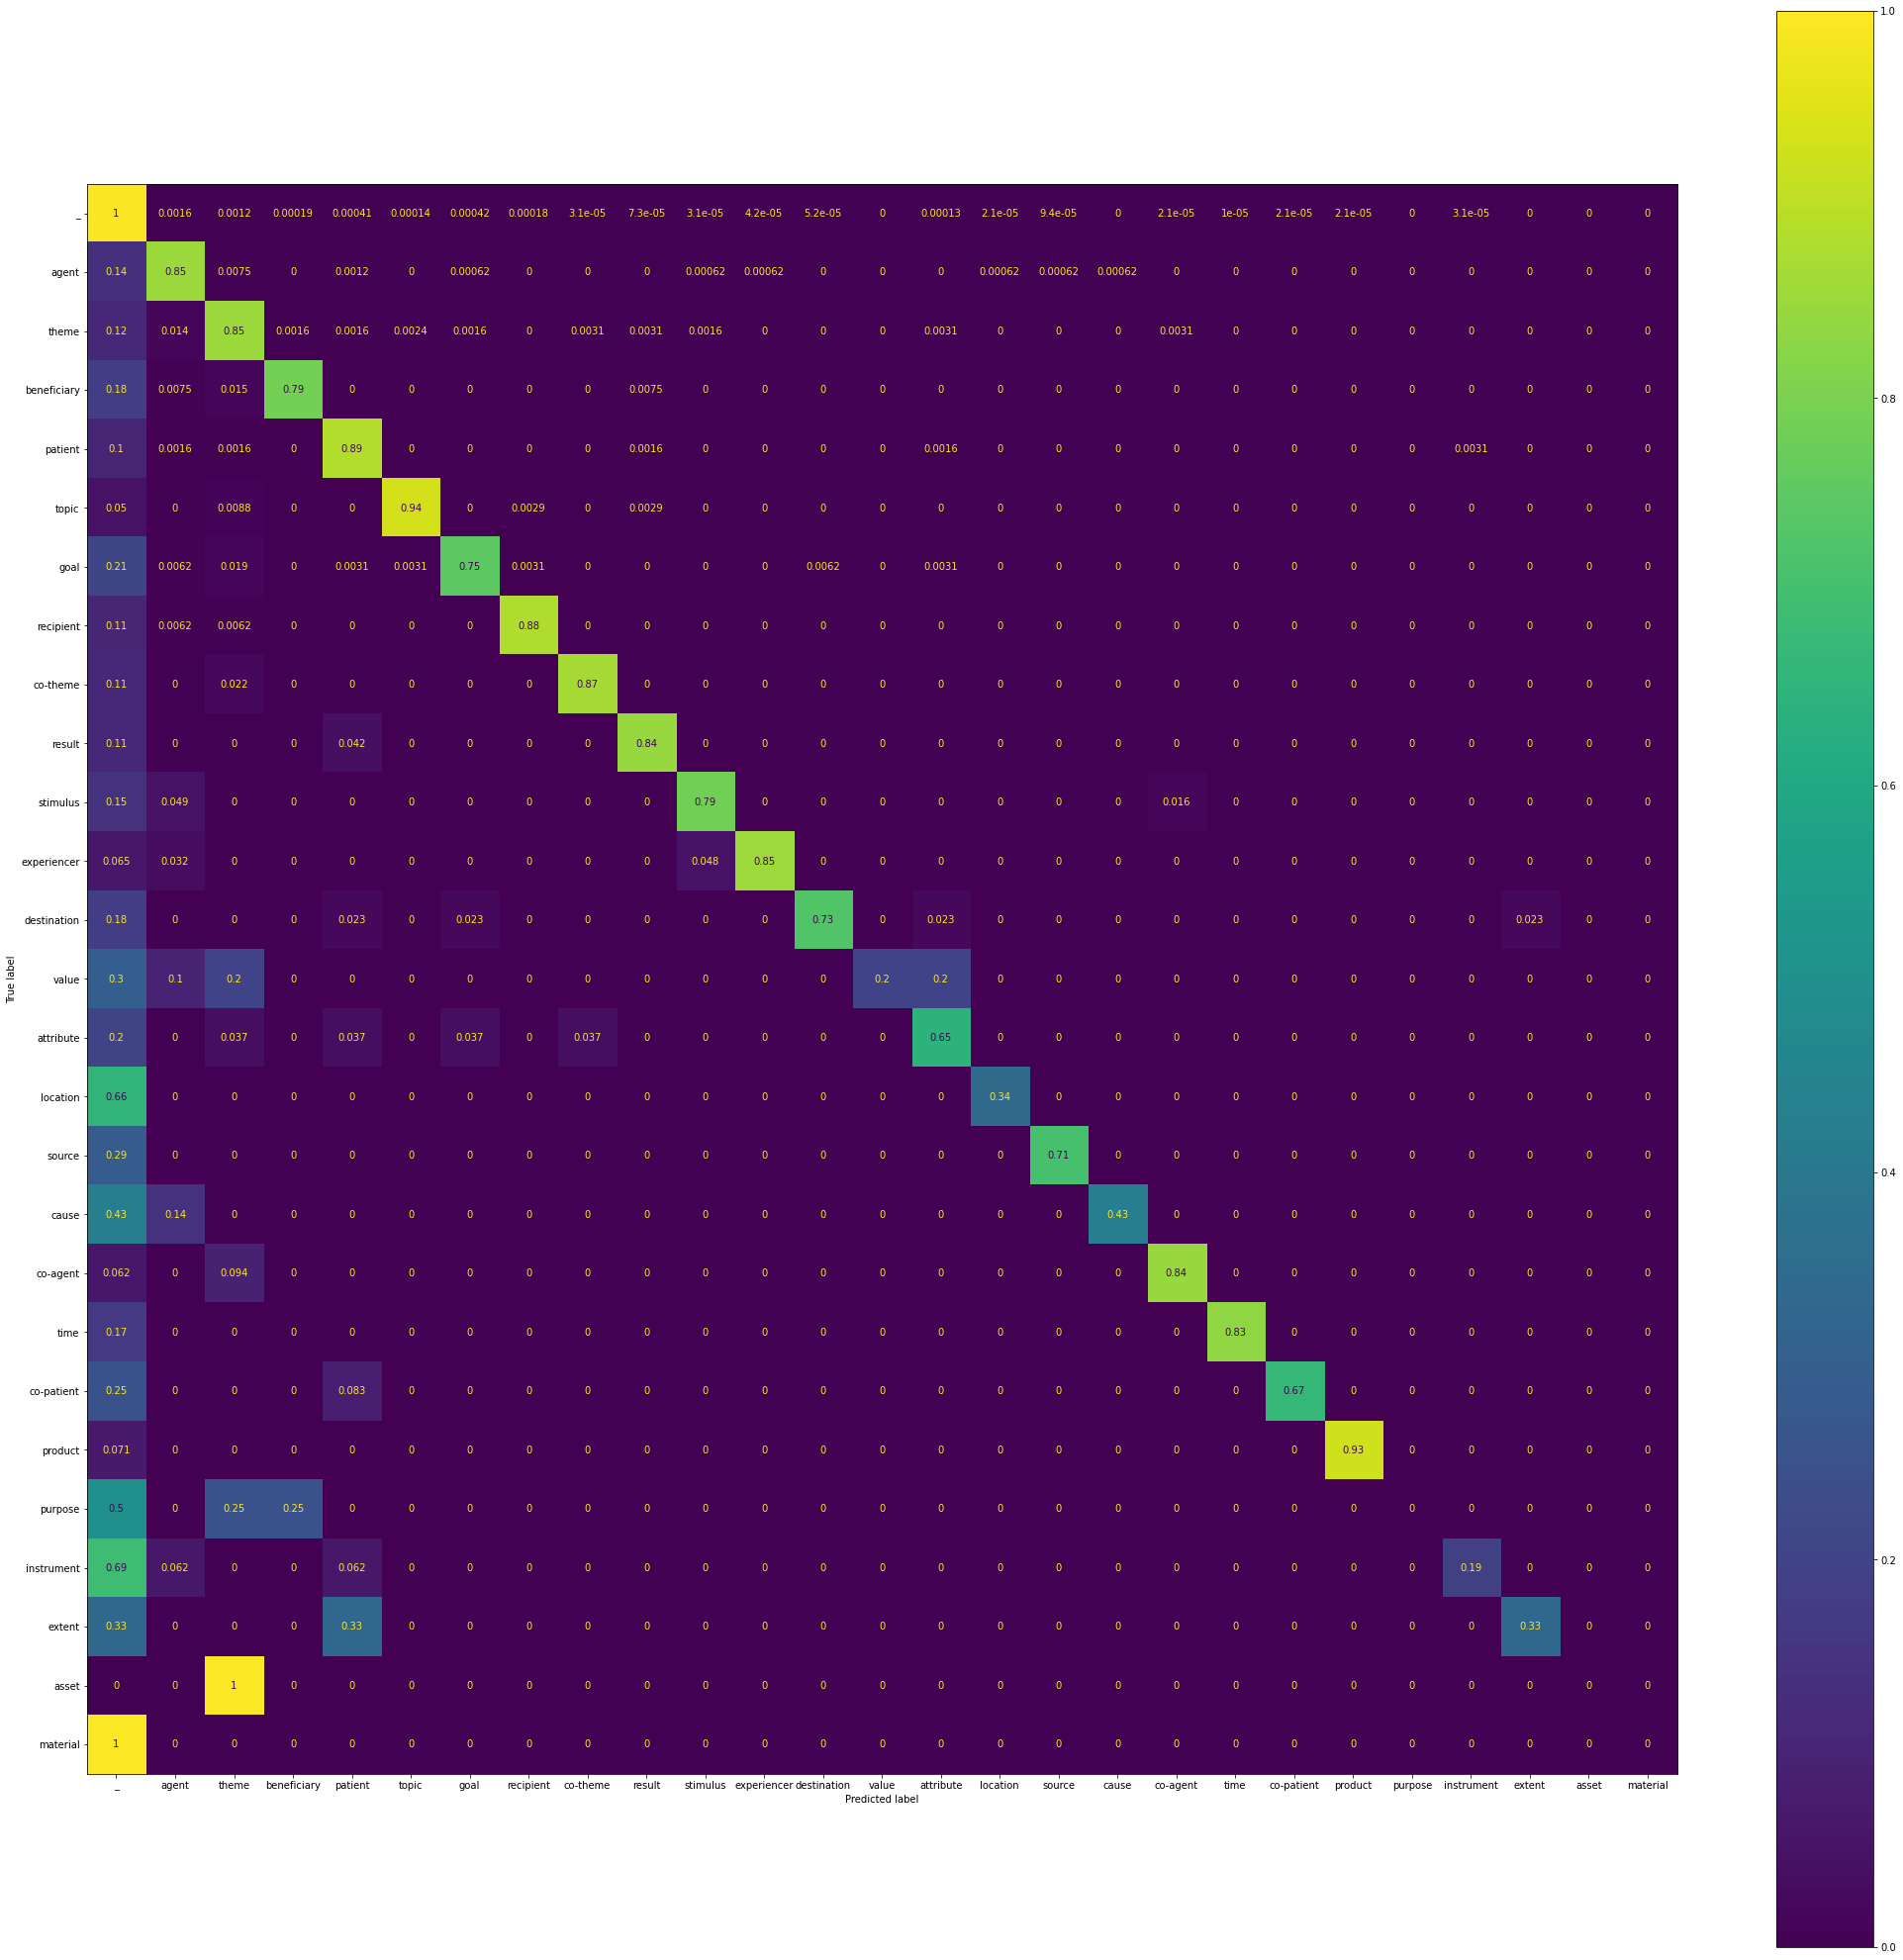

In [42]:
print("AI")
print(evaluate_argument_identification(sentences_test, predict))
print("AC")
print(evaluate_argument_classification(sentences_test, predict))

flat_labels_s = flat_dict_roles(sentences_test)
flat_predictions_s = flat_dict_roles(predict)

all_labels = ['_', 'agent', 'theme', 'beneficiary', 'patient', 'topic', 'goal', 'recipient', 'co-theme', 'result', \
    'stimulus', 'experiencer', 'destination', 'value', 'attribute', 'location', 'source', 'cause', 'co-agent', \
    'time', 'co-patient', 'product', 'purpose', 'instrument', 'extent', 'asset', 'material']

cm = confusion_matrix(flat_labels_s, flat_predictions_s, labels=all_labels, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
fig, ax = plt.subplots(figsize=(36,36))
disp.plot(ax=ax) #7162

As expected the fewer the samples the worst the performances.

### Evaluate predicate identification and disambiguation

In [93]:
from utils import evaluate_predicate_identification, evaluate_predicate_identification
best_ckpt2 = "../../model/SRL_1234_EN.ckpt"
# we load weights in a not strict fashion since I made some adjustment to the models during the way 
model2 = SRL_Model.load_from_checkpoint(best_ckpt2, strict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [94]:
if task == "1234":
    # note the trainig parameter set to True due to the fact that at training time we focus on task 1.
    predict2 = model2.to(device).predict(sentences_test, require_ids=True, training=True)
    print(evaluate_predicate_identification(sentences_test, predict2))
elif task == "234":
    predict2 = model2.to(device).predict(sentences_test, require_ids=True)
    print(evaluate_predicate_disambiguation(sentences_test, predict2))

{'true_positives': 2476, 'false_positives': 193, 'false_negatives': 77, 'precision': 0.9276882727613338, 'recall': 0.9698394046220133, 'f1': 0.948295672156262}


### Task 234 - AMuSE-WSD extra

Since for task 1(234) and task 34 I've basically implemented a very robust architecture that for some time had the SOTA results, it's clear that repeating something similar for 234 will lead to best results. Instead of doing a boring almost copy-paste of the other models where this time we could replace the post-tag with the pre-computed WSD predicts or simply the predicate identification, I've decided to first try a different approach using the suggested architecture AMuSE-WSD that currently has SOTA for WSD in multiple languages.

What I decided to do is indeed a fun but sub-optimal procedure: I start by predicting the meaning with AMuSE-WSD that uses more frames that the ones we have in the english dataset (the one I'll use as reference), so at this point I fine tune the predictions, also to remove the OOV prediction, to the most common real values for the training dataset, in a certain sense we are fine-tuning a model by applying a "filter layer" to increase the predictions! 

 For doing so I'll use all the different dataset informations since this model is intended to be used on different languages.

In [96]:
from amuse import AMuSE_WSD_online
from utils import evaluate_predicate_disambiguation

# extracted above from english dataset analysis
frames_in_dataset = ['_', 'ASK_REQUEST', 'BENEFIT_EXPLOIT', 'PLAN_SCHEDULE', 'CARRY-OUT-ACTION', 'ESTABLISH', 'SIMPLIFY', 'PROPOSE', 'TAKE-INTO-ACCOUNT_CONSIDER', 'BEGIN', 'CIRCULATE_SPREAD_DISTRIBUTE', 'REFER', 'SHOW', 'PRECLUDE_FORBID_EXPEL', 'VIOLATE', 'VERIFY', 'CAUSE-SMT', 'ABSTAIN_AVOID_REFRAIN', 'TRANSMIT', 'SEE', 'SUMMON', 'GUARANTEE_ENSURE_PROMISE', 'RECEIVE', 'INCREASE_ENLARGE_MULTIPLY', 'DECREE_DECLARE', 'PAY', 'CAUSE-MENTAL-STATE', 'CAGE_IMPRISON', 'HURT_HARM_ACHE', 'MOVE-BACK', 'EXIST_LIVE', 'CALCULATE_ESTIMATE', 'ATTRACT_SUCK', 'EXIST-WITH-FEATURE', 'INFORM', 'EXPLAIN', 'SPEAK', 'SEEM', 'MISS_OMIT_LACK', 'DECIDE_DETERMINE', 'ASSIGN-SMT-TO-SMN', 'FOLLOW_SUPPORT_SPONSOR_FUND', 'MOVE-ONESELF', 'WORSEN', 'AMELIORATE', 'AGREE_ACCEPT', 'MOVE-SOMETHING', 'PUT_APPLY_PLACE_PAVE', 'ADJUST_CORRECT', 'INCLUDE-AS', 'CONTINUE', 'SPEED-UP', 'LOAD_PROVIDE_CHARGE_FURNISH', 'REMEMBER', 'FINISH_CONCLUDE_END', 'REPEAT', 'HELP_HEAL_CARE_CURE', 'IMPLY', 'OPPOSE_REBEL_DISSENT', 'STRENGTHEN_MAKE-RESISTANT', 'AROUSE_WAKE_ENLIVEN', 'RECORD', 'INCITE_INDUCE', 'GIVE_GIFT', 'DESTROY', 'REQUIRE_NEED_WANT_HOPE', 'ANALYZE', 'COME-AFTER_FOLLOW-IN-TIME', 'BELIEVE', 'GO-FORWARD', 'CANCEL_ELIMINATE', 'RECOGNIZE_ADMIT_IDENTIFY', 'CHOOSE', 'REPRESENT', 'TREAT', 'OBLIGE_FORCE', 'STOP', 'REACT', 'HAPPEN_OCCUR', 'OVERCOME_SURPASS', 'AFFECT', 'CREATE_MATERIALIZE', 'ALLY_ASSOCIATE_MARRY', 'MANAGE', 'OPEN', 'ORIENT', 'ANSWER', 'INFLUENCE', 'COMBINE_MIX_UNITE', 'LEAD_GOVERN', 'STAY_DWELL', 'WELCOME', 'AMASS', 'PREPARE', 'ORGANIZE', 'HAVE-A-FUNCTION_SERVE', 'GIVE-UP_ABOLISH_ABANDON', 'SORT_CLASSIFY_ARRANGE', 'GIVE-BIRTH', 'PUBLISH', 'USE', 'POSSESS', 'BEHAVE', 'WORK', 'SUBJECTIVE-JUDGING', 'APPROVE_PRAISE', 'ATTEND', 'LEAVE_DEPART_RUN-AWAY', 'CATCH', 'OBEY', 'SATISFY_FULFILL', 'UNDERSTAND', 'ACHIEVE', 'TRY', 'ATTACH', 'INTERPRET', 'DELAY', 'REDUCE_DIMINISH', 'UNDERGO-EXPERIENCE', 'RETAIN_KEEP_SAVE-MONEY', 'ARRIVE', 'REFUSE', 'IMAGINE', 'HARMONIZE', 'PARTICIPATE', 'HIRE', 'RESULT_CONSEQUENCE', 'FOCUS', 'CONTAIN', 'MOUNT_ASSEMBLE_PRODUCE', 'PROVE', 'WRITE', 'RESTRAIN', 'TOLERATE', 'ACCOMPANY', 'DISCUSS', 'RESTORE-TO-PREVIOUS/INITIAL-STATE_UNDO_UNWIND', 'TEACH', 'CHANGE-APPEARANCE/STATE', 'INVERT_REVERSE', 'RELY', 'SIGNAL_INDICATE', 'LEARN', 'ACCUSE', 'PERFORM', 'AFFIRM', 'REMOVE_TAKE-AWAY_KIDNAP', 'WATCH_LOOK-OUT', 'GROUND_BASE_FOUND', 'LEAVE-BEHIND', 'FACE_CHALLENGE', 'CHANGE_SWITCH', 'SHARE', 'APPLY', 'ARGUE-IN-DEFENSE', 'DIRECT_AIM_MANEUVER', 'WAIT', 'HEAR_LISTEN', 'CONSIDER', 'LIKE', 'FIGHT', 'PROTECT', 'AUTHORIZE_ADMIT', 'DIVERSIFY', 'PRESERVE', 'LOCATE-IN-TIME_DATE', 'SEND', 'ORDER', 'SEARCH', 'REGRET_SORRY', 'EMPHASIZE', 'CELEBRATE_PARTY', 'TAKE-SHELTER', 'HOST_MEAL_INVITE', 'REPLACE', 'THINK', 'MEET', 'PERCEIVE', 'BREAK_DETERIORATE', 'JOIN_CONNECT', 'BORDER', 'FIND', 'KNOW', 'KILL', 'CHARGE', 'FAIL_LOSE', 'CRITICIZE', 'CITE', 'HIT', 'LIBERATE_ALLOW_AFFORD', 'BRING', 'DERIVE', 'JUSTIFY_EXCUSE', 'PERSUADE', 'REVEAL', 'DRIVE-BACK', 'TAKE', 'OBTAIN', 'LOSE', 'ADD', 'MATCH', 'CONSUME_SPEND', 'COMPARE', 'BEFRIEND', 'NAME', 'BE-LOCATED_BASE', 'OFFER', 'OVERLAP', 'CARRY_TRANSPORT', 'REACH', 'FILL', 'ENCLOSE_WRAP', 'DISBAND_BREAK-UP', 'COUNT', 'DEFEAT', 'CO-OPT', 'ENDANGER', 'PUNISH', 'TRANSLATE', 'SECURE_FASTEN_TIE', 'INSERT', 'REMAIN', 'BUY', 'STEAL_DEPRIVE', 'SETTLE_CONCILIATE', 'EXTEND', 'SUMMARIZE', 'PUBLICIZE', 'CORRELATE', 'SEPARATE_FILTER_DETACH', 'GROUP', 'COST', 'ATTACK_BOMB', 'WARN', 'NEGOTIATE', 'ENTER', 'LIE', 'SPEND-TIME_PASS-TIME', 'EMPTY_UNLOAD', 'INVERT_REVERSE-', 'EMIT', 'TURN_CHANGE-DIRECTION', 'SELL', 'GUESS', 'DISCARD', 'CONTRACT-AN-ILLNESS_INFECT', 'WASH_CLEAN', 'DROP', 'OPERATE', 'SHARPEN', 'REFLECT', 'COMPENSATE', 'ASCRIBE', 'LOWER', 'COPY', 'DEBASE_ADULTERATE', 'DISMISS_FIRE-SMN', 'COVER_SPREAD_SURMOUNT', 'MEASURE_EVALUATE', 'RESIGN_RETIRE', 'READ', 'DISTINGUISH_DIFFER', 'TRAVEL', 'RESIST', 'SHOOT_LAUNCH_PROPEL', 'BURDEN_BEAR', 'SOLVE', 'WIN', 'APPEAR', 'FOLLOW-IN-SPACE', 'PULL', 'PAINT', 'COME-FROM', 'VISIT', 'COOL', 'DOWNPLAY_HUMILIATE', 'CHASE', 'EMBELLISH', 'EARN', 'RAISE', 'PROMOTE', 'MEAN', 'EXHAUST', 'ABSORB', 'PRESS_PUSH_FOLD', 'LEND', 'SHAPE', 'PRINT', 'REPAIR_REMEDY', 'GROW_PLOW', 'QUARREL_POLEMICIZE', 'TAKE-A-SERVICE_RENT', 'COMPETE', 'DIVIDE', 'COMMUNICATE_CONTACT', 'FIT', 'EXEMPT', 'SLOW-DOWN', 'FLOW', 'RISK', 'METEOROLOGICAL', 'NOURISH_FEED', 'STABILIZE_SUPPORT-PHYSICALLY']
mod = AMuSE_WSD_online(language, filter_layer=False)

In [97]:
filter = dict()
# uncomment if you have slow internet like me and want to test on english dataset
# it is the result of mod.predict(sentences, require_ids=True) using words
# the online pipeline is better working with words than lemmas because it is tought to be a full end-to-end state-of-the-art 
# multilingual pretrained model.
# pred = torch.load("../../model/amuse/predictions_words_EN") 

# comment if you have slow internet
pred = mod.predict(sentences, require_ids=True)

print(evaluate_predicate_disambiguation(pred, sentences))
# oov_labels = 0
possibilities = dict()
for p in pred:
    for predict, real in zip(pred[p]["predicates"], sentences[p]["predicates"]):
        possibilities[predict] = possibilities.get(predict,{})
        possibilities[predict][real] = possibilities[predict].get(real,0) + 1
# if oov_labels == 0:
#     # we end the training, we have all inside our labels_vocabulary
#     break
for k in possibilities:
    max_count = 0
    max_label = ""
    for j in possibilities[k]:
        if possibilities[k][j] > max_count:
            max_count = possibilities[k][j]
            max_label = j
    filter[k] = max_label
# code to avoid spending time in recumputing everything with mod.predict
new_pred = dict()
for k in pred:
    new_pred[k] = {"predicates" : [filter[s] for s in pred[k]["predicates"]]}
print(evaluate_predicate_disambiguation(new_pred, sentences))

# RESULTS:
# - english
#     {'true_positives': 8838, 'false_positives': 3724, 'false_negatives': 2878, 
#     'precision': 0.7035503900652762, 'recall': 0.7543530215090475, 'f1': 0.7280665623197956}
#     {'true_positives': 9229, 'false_positives': 3333, 'false_negatives': 2487, 
#     'precision': 0.7346760070052539, 'recall': 0.7877261864117446, 'f1': 0.7602767938050911}
#     Output exceeds the size limit. Open the full output data in a text editor
# - spanish
#     {'true_positives': 566, 'false_positives': 509, 'false_negatives': 456, 
#     'precision': 0.5265116279069767, 'recall': 0.5538160469667319, 'f1': 0.5398187887458273}
#     {'true_positives': 651, 'false_positives': 424, 'false_negatives': 371, 
#     'precision': 0.6055813953488373, 'recall': 0.636986301369863, 'f1': 0.6208869814020028}
# - french
#    {'true_positives': 183, 'false_positives': 938, 'false_negatives': 301, 
#    'precision': 0.1632471008028546, 'recall': 0.378099173553719, 'f1': 0.22803738317757014}
#    {'true_positives': 302, 'false_positives': 819, 'false_negatives': 182, 
#    'precision': 0.2694023193577163, 'recall': 0.6239669421487604, 'f1': 0.37632398753894075}

# # # EXTRA predict french using language = "EN" in the request:
# {'true_positives': 22, 'false_positives': 1099, 'false_negatives': 127, 
# 'precision': 0.019625334522747548, 'recall': 0.1476510067114094, 'f1': 0.03464566929133858}
# {'true_positives': 84, 'false_positives': 1037, 'false_negatives': 65, 
# 'precision': 0.07493309545049064, 'recall': 0.5637583892617449, 'f1': 0.13228346456692913}



{'true_positives': 8838, 'false_positives': 3724, 'false_negatives': 2878, 'precision': 0.7035503900652762, 'recall': 0.7543530215090475, 'f1': 0.7280665623197956}
{'true_positives': 9229, 'false_positives': 3333, 'false_negatives': 2487, 'precision': 0.7346760070052539, 'recall': 0.7877261864117446, 'f1': 0.7602767938050911}


Now we conclude with this section repeating the experiment with and without the filter for the dev_set, then we save all these predictions and filter to work with a "fine tuned" amuse-wsd. 

In [98]:
pred_test = mod.predict(sentences_test, require_ids=True)
print(evaluate_predicate_disambiguation(pred_test, sentences_test))
mod.filter = filter
new_pred_test = mod.predict(sentences_test, require_ids=True)
print(evaluate_predicate_disambiguation(new_pred_test, sentences_test))

# RESULTS:
# - english
#     {'true_positives': 1782, 'false_positives': 771, 'false_negatives': 546, 
#     'precision': 0.6980023501762632, 'recall': 0.7654639175257731, 'f1': 0.7301782421634909}
#     {'true_positives': 1841, 'false_positives': 712, 'false_negatives': 487, 
#     'precision': 0.7211124167645907, 'recall': 0.790807560137457, 'f1': 0.7543536160622824}
# - spanish
#     {'true_positives': 1291, 'false_positives': 1204, 'false_negatives': 1108, 
#     'precision': 0.5174348697394789, 'recall': 0.5381408920383494, 'f1': 0.5275847977114835}
#     {'true_positives': 1325, 'false_positives': 1170, 'false_negatives': 1074, 
#     'precision': 0.531062124248497, 'recall': 0.5523134639433097, 'f1': 0.5414793624846751}
# - french
#     {'true_positives': 414, 'false_positives': 2141, 'false_negatives': 636, 
#      'precision': 0.16203522504892368, 'recall': 0.3942857142857143, 'f1': 0.22968099861303742}
#     {'true_positives': 424, 'false_positives': 2131, 'false_negatives': 626, 
#     'precision': 0.1659491193737769, 'recall': 0.4038095238095238, 'f1': 0.2352288488210818}


{'true_positives': 1782, 'false_positives': 771, 'false_negatives': 546, 'precision': 0.6980023501762632, 'recall': 0.7654639175257731, 'f1': 0.7301782421634909}
{'true_positives': 1841, 'false_positives': 712, 'false_negatives': 487, 'precision': 0.7211124167645907, 'recall': 0.790807560137457, 'f1': 0.7543536160622824}


In [ ]:
# note the "2" to avoid override previous computations
torch.save(new_pred, f"../../model/amuse/prediction_words_new_{language}2")
torch.save(new_pred_test, f"../../model/amuse/prediction_words_dev_new_{language}2")
torch.save(filter, f"../../model/amuse/filter_layer_{language}2")